In [386]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix

In [387]:
df = pd.read_csv(r"D:\vs code\Projects\MachineLearning\Spamclassifier\spam.csv",encoding="ansi")

## Exploratory Data Analysis

In [388]:
df["v1"].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x2150a6e1370>,
 [Text(0.479940630347798, -0.9897762329644809, 'ham'),
  Text(-0.47994000893356403, 0.9897765342868311, 'spam')],
 [Text(0.26178579837152616, -0.5398779452533532, '86.6%'),
  Text(-0.2617854594183076, 0.5398781096109987, '13.4%')])

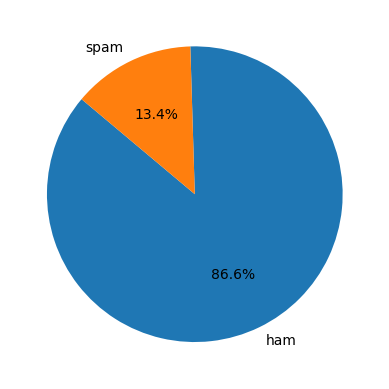

In [389]:
plt.pie(df["v1"].value_counts(), labels=["ham", "spam"], autopct='%1.1f%%', startangle=140)

### Visualising average Word length of spam vs ham

v1
ham     14.200622
spam    23.851406
Name: word_count, dtype: float64


<BarContainer object of 2 artists>

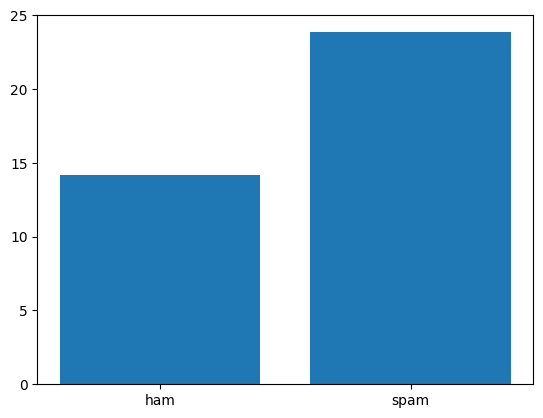

In [390]:
def counter(text):
    return len(text.split())
df["word_count"] = df["v2"].apply(counter)
avg_len = df.groupby("v1")["word_count"].mean()
print(avg_len)
plt.bar(avg_len.index, avg_len.values)

### Word Cloud For Spam And Ham

In [391]:
from wordcloud import WordCloud

In [392]:
spam_words = " ".join(df[df["v1"]== "spam"]["v2"])
ham_words = " ".join(df[df["v1"]== "ham"]["v2"])

In [393]:
spam_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(spam_words)

ham_wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="viridis").generate(ham_words)

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

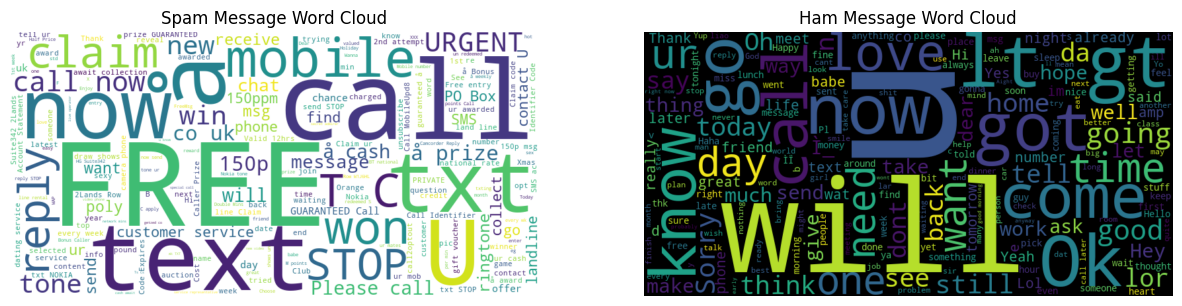

In [394]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation="bilinear")
plt.title("Spam Message Word Cloud")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation="bilinear")
plt.title("Ham Message Word Cloud")
plt.axis("off")

## Data Cleaning

### Removing Unamed Columns

In [395]:
df.head()
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4","word_count"])

### Removing Dulpicates

In [396]:
df.duplicated().sum()
df.drop_duplicates(keep="first",inplace = True)

### Label Encoding

In [397]:
le = LabelEncoder()
df["v1"] = le.fit_transform(df["v1"])
print(df["v1"].value_counts())

v1
0    4516
1     653
Name: count, dtype: int64


## TEXT PREPROCESSING

### Lowercasing

In [398]:
columns_to_lowercase = ["v1", "v2"]
for col in columns_to_lowercase:
    if col in df.columns:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].astype(str).str.lower()
            print(f"Column '{col}' has been lowercased.")
df.head()

Column 'v2' has been lowercased.


,v1,v2
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


### Url removal

In [399]:

import re
url_pattern = re.compile(r'https?://\S+|www\.\S+|\S+\.(com|org|net|gov|edu|uk|ca|in|io|co|biz|info|xyz|me|app|dev|blog|shop|online|site|store|tech|club|live|solutions|ai|io|cloud)\b')
def remove_urls(text):
    text = str(text) # Ensure text is string
    return url_pattern.sub(r'', text)
df["v2_nourl"] = df["v2"].apply(remove_urls)
df["v2_nourl"][15]

'xxxmobilemovieclub: to use your credit, click the wap link in the next txt message or click here>>  ?n=qjkgighjjgcbl'

### Punctuation removal

In [400]:
def clean_text(text):
    return str(text).translate(str.maketrans('', '', string.punctuation)).strip()

df["v2_clean"] = df["v2_nourl"].apply(clean_text)
df["v2_clean"].head()

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: v2_clean, dtype: object

### Chat Word Removal

In [401]:
chat_words_map = {
    'lol': 'laughing out loud',
    'brb': 'be right back',
    'g2g': 'got to go',
    'btw': 'by the way',
    'omg': 'oh my god',
    'wtf': 'what the fuck',
    'u': 'you',
    'r': 'are',
    'ur': 'your',
    'lyk': 'like',
    '2': 'to',
    '4': 'for',
    'cya': 'see you',
    'msg': 'message',
    'pls': 'please',
    'plz': 'please',
    'thx': 'thanks',
    'ty': 'thank you',
    'coz': 'because',
    'b4': 'before',
    'idk': 'i do not know',
    'imo': 'in my opinion',
    'irl': 'in real life',
    'fyi': 'for your information',
    'np': 'no problem',
    'ttyl': 'talk to you later',
    'wbu': 'what about you',
    'c' : 'can',
    'n':'and',
    'k':'ok',
    'dun' : 'dont'
}
def expand_word(text):
    words = text.split()
    expanded_words = []
    for word in words:
        if word in chat_words_map.keys():
            expanded_words.append(chat_words_map[word])
        else:
            expanded_words.append(word)
    return ' '.join(expanded_words)

df["v2_expChat"] = df["v2_clean"].apply(expand_word)
df["v2_expChat"].head()

0    go until jurong point crazy available only in ...
1                            ok lar joking wif you oni
2    free entry in to a wkly comp to win fa cup fin...
3    you dont say so early hor you can already then...
4    nah i dont think he goes to usf he lives aroun...
Name: v2_expChat, dtype: object

### Removal Of Stop Word

In [402]:
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words("english"))
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)
df["v2_nostop"] = df["v2_expChat"].apply(remove_stopwords)
df["v2_nostop"].head()

0    go jurong point crazy available bugis great wo...
1                                ok lar joking wif oni
2    free entry wkly comp win fa cup final tkts 21s...
3                       dont say early hor already say
4          nah dont think goes usf lives around though
Name: v2_nostop, dtype: object

### Lemmatization and Tokenization

In [403]:
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('punkt_tab')
def lema_tokenize(text):
    lemma = WordNetLemmatizer()
    token = word_tokenize(text)
    lemma_word = [lemma.lemmatize(x) for x in token]
    return " ".join(lemma_word)
df["v2_lema"] = df["v2_nostop"].apply(lema_tokenize)

In [404]:
df.drop(columns=["v2", "v2_nourl", "v2_clean", "v2_expChat","v2_nostop"], inplace=True)
df.rename(columns={"v2_lema": "v2"}, inplace=True)

In [405]:
df["v2"][0]

'go jurong point crazy available bugis great world la e buffet cine got amore wat'

## Text Representation

### Tfidf

In [406]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3200)
X_tfidf = tfidf_vectorizer.fit_transform(df["v2"])

Normalization

In [407]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(X_tfidf.toarray())

## Text Classification

In [408]:
X_tfidf = tfidf_vectorizer.fit_transform(df["v2"])
y = df["v1"]

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
	X_tfidf, y, test_size=0.2, random_state=42
)

### SVM

In [409]:
from sklearn.svm import SVC

svm_model = SVC(C=10 , kernel = 'rbf',gamma=1)
svm_model.fit(X_train_tfidf, y_train)

AttributeError: 'bool' object has no attribute 'all'

AttributeError: 'bool' object has no attribute 'all'

SVC(C=10, gamma=1)

### Grid Search For best parameters

In [410]:
# svm_para = {
#     'C': [0.1, 1, 10],
#     'gamma': [0.001, 0.01, 0.1],
#     'kernel': ['linear', 'rbf']
# }
# grid_search = GridSearchCV(SVC(), svm_para, cv=5, scoring='accuracy')
# grid_search.fit(X_train_tfidf, y_train)
# print(grid_search.best_params_)

In [411]:
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm * 100:.2f}%_")
precision_svm = precision_score(y_test, y_pred_svm)
print(f"Precision (Spam): {precision_svm:.4f}")
recall_svm = recall_score(y_test, y_pred_svm)
print(f"Recall (Spam): {recall_svm:.4f}")
f1_svm = f1_score(y_test, y_pred_svm)
print(f"F1-Score (Spam): {f1_svm:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(conf_matrix_svm)

SVM Accuracy: 97.68%_
Precision (Spam): 0.9919
Recall (Spam): 0.8414
F1-Score (Spam): 0.9104
--- Confusion Matrix ---
[[888   1]
 [ 23 122]]


### Naive bayes

In [412]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB

Multinomial Naive Bayes(One with Best Precision)

In [413]:
Multinb_model = MultinomialNB()
Multinb_model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Random Search to preserve resources

In [414]:
# nb_para = {
#     "alpha": [0.1, 0.5, 1.0, 2.0],
#     "force_alpha": [True, False],
#     "fit_prior": [True, False],
#     "class_prior": [None, [0.5, 0.5]]
# }
# scoring_metrics = {
#     "precision": "precision",
#     "recall": "recall",
#     "accuracy": "accuracy"
# }


# random_search = GridSearchCV(Multinb_model, nb_para, cv=5, scoring=scoring_metrics, refit="precision")
# random_search.fit(X_train_tfidf, y_train)
# print(random_search.best_params_)
# print(random_search.best_score_)

In [415]:
y_pred_Multinb = Multinb_model.predict(X_test_tfidf)
accuracy_Multinb = accuracy_score(y_test,y_pred_Multinb)
print(f"Multinomial Naive Bayes Accuracy: {accuracy_Multinb * 100:.2f}%")
precision_Multinb = precision_score(y_test, y_pred_Multinb)
print(f"Precision (Spam): {precision_Multinb:.4f}")
recall_Multinb = recall_score(y_test, y_pred_Multinb)
print(f"Recall (Spam): {recall_Multinb:.4f}")
f1_Multinb = f1_score(y_test, y_pred_Multinb)
print(f"F1-Score (Spam): {f1_Multinb:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_Multinb = confusion_matrix(y_test, y_pred_Multinb)
print(conf_matrix_Multinb)

Multinomial Naive Bayes Accuracy: 97.29%
Precision (Spam): 1.0000
Recall (Spam): 0.8069
F1-Score (Spam): 0.8931
--- Confusion Matrix ---
[[889   0]
 [ 28 117]]


Gaussian Naive Bayes

In [416]:
Gausnb_model = GaussianNB(priors=None, var_smoothing=1e-9)
Gausnb_model.fit(X_train_tfidf.toarray(), y_train)

,priors,None
,var_smoothing,1e-09


In [417]:
# gnb_para = {
#     "priors": [None, [0.5, 0.5]],
#     "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
# }
# scoring_metrics = {
#     "precision": "precision",
#     "recall": "recall",
#     "accuracy": "accuracy"
# }


# grid_search = GridSearchCV(Gausnb_model, gnb_para, cv=5, scoring=scoring_metrics, refit="accuracy")
# grid_search.fit(X_train_tfidf.toarray(), y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [418]:
y_pred_Gausnb = Gausnb_model.predict(X_test_tfidf.toarray())
accuracy_Gausnb = accuracy_score(y_test, y_pred_Gausnb)
print(f"Gaussian Naive Bayes Accuracy: {accuracy_Gausnb * 100:.2f}%")
precision_Gausnb = precision_score(y_test, y_pred_Gausnb)
print(f"Precision (Spam): {precision_Gausnb:.4f}")
recall_Gausnb = recall_score(y_test, y_pred_Gausnb)
print(f"Recall (Spam): {recall_Gausnb:.4f}")
f1_Gausnb = f1_score(y_test, y_pred_Gausnb)
print(f"F1-Score (Spam): {f1_Gausnb:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_Gausnb = confusion_matrix(y_test, y_pred_Gausnb)
print(conf_matrix_Gausnb)

Gaussian Naive Bayes Accuracy: 87.91%
Precision (Spam): 0.5450
Recall (Spam): 0.8345
F1-Score (Spam): 0.6594
--- Confusion Matrix ---
[[788 101]
 [ 24 121]]


Bernoulli Naive Bayes

In [419]:
bern_model = BernoulliNB()
bern_model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


In [420]:
# bnb_para = {
#     "alpha": [0.1, 0.5, 1.0, 2.0],
#     "force_alpha": [True, False],
#     "fit_prior": [True, False],
#     "class_prior": [None, [0.5, 0.5]],
#     "binarize" : [True, False]
# }
# scoring_metrics = {
#     "precision": "precision",
#     "recall": "recall",
#     "accuracy": "accuracy"
# }


# grid_search = GridSearchCV(bern_model, bnb_para, cv=5, scoring=scoring_metrics, refit="precision")
# grid_search.fit(X_train_tfidf.toarray(), y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [421]:
y_pred_bern = bern_model.predict(X_test_tfidf)
accuracy_bern = accuracy_score(y_test, y_pred_bern)
print(f"Bernoulli Naive Bayes Accuracy: {accuracy_bern * 100:.2f}%")
precision_bern = precision_score(y_test, y_pred_bern)
print(f"Precision (Spam): {precision_bern:.4f}")
recall_bern = recall_score(y_test, y_pred_bern)
print(f"Recall (Spam): {recall_bern:.4f}")
f1_bern = f1_score(y_test, y_pred_bern)
print(f"F1-Score (Spam): {f1_bern:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_bern = confusion_matrix(y_test, y_pred_bern)
print(conf_matrix_bern)

Bernoulli Naive Bayes Accuracy: 97.68%
Precision (Spam): 0.9919
Recall (Spam): 0.8414
F1-Score (Spam): 0.9104
--- Confusion Matrix ---
[[888   1]
 [ 23 122]]


### Logistic regression

In [422]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
LR_model.fit(X_train_tfidf,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [423]:
from sklearn.model_selection import RandomizedSearchCV

In [424]:
# lr_para = {
#     "penalty": ["l2", "none"],
#     "C": [0.1, 1.0, 10.0],
#     "solver": ["lbfgs", "sag", "saga"],
#     "max_iter": [100, 200, 300],
#     "class_weight": [None, "balanced"],
#     "fit_intercept": [True, False],
#     "intercept_scaling": [1, 2, 3]
# }
# scoring_metrics = {
#     "precision": "precision",
#     "recall": "recall",
#     "accuracy": "accuracy"
# }


# ran_search = RandomizedSearchCV(LR_model, lr_para, cv=5, scoring=scoring_metrics, refit="precision")
# ran_search.fit(X_train_tfidf.toarray(), y_train)
# print(ran_search.best_params_)
# print(ran_search.best_score_)

In [425]:
y_pred_LR = LR_model.predict(X_test_tfidf)
accuracy_LR = accuracy_score(y_test,y_pred_LR)
print(f"Logistic Regression Accuracy: {accuracy_LR * 100:.2f}%")
precision_LR = precision_score(y_test, y_pred_LR)
print(f"Precision (Spam): {precision_LR:.4f}")
recall_LR = recall_score(y_test, y_pred_LR)
print(f"Recall (Spam): {recall_LR:.4f}")
f1_LR = f1_score(y_test, y_pred_LR)
print(f"F1-Score (Spam): {f1_LR:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)
print(conf_matrix_LR)

Logistic Regression Accuracy: 94.78%
Precision (Spam): 0.9252
Recall (Spam): 0.6828
F1-Score (Spam): 0.7857
--- Confusion Matrix ---
[[881   8]
 [ 46  99]]


### KNN

In [426]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train_tfidf,y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [427]:
y_pred_KNN = KNN_model.predict(X_test_tfidf)
accuracy_knn = accuracy_score(y_test,y_pred_KNN)
print(f"KNN Accuracy: {accuracy_knn * 100:.2f}%")
precision_knn = precision_score(y_test,y_pred_KNN)
print(f"Precision (Spam): {precision_knn:.4f}")
recall_knn = recall_score(y_test,y_pred_KNN)
print(f"Recall (Spam): {recall_knn:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_knn = confusion_matrix(y_test,y_pred_KNN)
print(conf_matrix_knn)

KNN Accuracy: 90.81%
Precision (Spam): 1.0000
Recall (Spam): 0.3448
--- Confusion Matrix ---
[[889   0]
 [ 95  50]]


### Random Forest

In [428]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier()
RF_model.fit(X_train_tfidf,y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [429]:
y_pred_rf = RF_model.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test,y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
precision_rf = precision_score(y_test,y_pred_rf)
print(f"Precision (Spam): {precision_rf:.4f}")
recall_rf = recall_score(y_test,y_pred_rf)
print(f"Recall (Spam): {recall_rf:.4f}")
print("--- Confusion Matrix ---")
conf_matrix_knn = confusion_matrix(y_test,y_pred_KNN)
print(conf_matrix_knn)

Random Forest Accuracy: 97.49%
Precision (Spam): 0.9917
Recall (Spam): 0.8276
--- Confusion Matrix ---
[[889   0]
 [ 95  50]]


### Comparision Graph

In [430]:
accuracy_scores = [accuracy_svm, accuracy_Multinb, accuracy_Gausnb, accuracy_bern, accuracy_LR, accuracy_knn, accuracy_rf]
precision_scores = [precision_svm, precision_Multinb, precision_Gausnb, precision_bern, precision_LR, precision_knn, precision_rf]
algorithms = ["SVM", "Multinomial NB", "Gaussian NB", "Bernoulli NB", "Logistic Regression", "KNN", "Random Forest"]

In [431]:
performance_df = pd.DataFrame({
    'Algorithm': algorithms,
    "Accuracy" : accuracy_scores,
    "Precision": precision_scores})
performance_df = pd.melt(performance_df,id_vars=['Algorithm'])

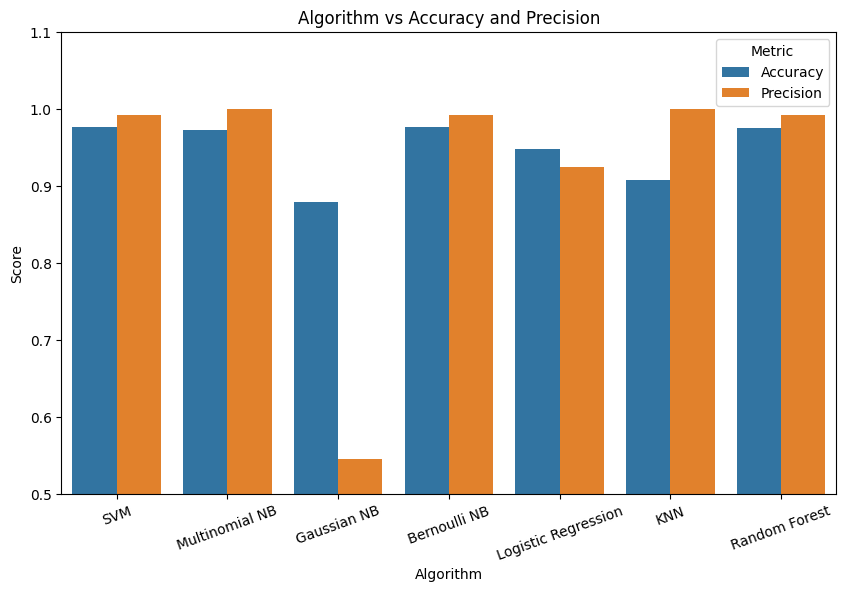

In [432]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=performance_df, x='Algorithm', y='value', hue='variable')
plt.ylabel('Score')
plt.title('Algorithm vs Accuracy and Precision')
plt.ylim(0.5, 1.1)
plt.legend(title='Metric')
plt.xticks(rotation=20)
plt.show()

## Exporting a Pickle File for website

In [433]:
import pickle
pickle.dump(tfidf_vectorizer, open("vectorizer.pkl", "wb"))
pickle.dump(Multinb_model, open("Multinb.pkl", "wb"))
pickle.dump(svm_model,open("svm_model.pkl","wb"))
pickle.dump(Gausnb_model,open("Gausnb_model.pkl","wb"))
pickle.dump(bern_model,open("bern_model.pkl","wb"))
pickle.dump(KNN_model,open("knn_model.pkl","wb"))
pickle.dump(LR_model,open("LR_model.pkl","wb"))
pickle.dump(RF_model,open("RF_model.pkl","wb"))